In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import re
import pickle
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('stopwords')
lemma = WordNetLemmatizer()

# Plotting tools
import sys
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ilyas\AppData\Roaming\nltk_data...


In [13]:
documents = ['На втором этаже не работает кондиционер, очень душно, невозможно работать.'
    ,'Сделайте кондиционер на втором этаже, жарко'
    ,'Нужен кондиционер на втором этаже, чтобы не было душно'
         ,'Хотелось бы кондиционер  на втором этаже, но нужно будет поставить его туда, где не сидят сотрудники, чтобы не дуло сильно'
        ,'Очень жарко в офисе, особенно на втором этаже, нужен кондиционер'
        ,'В кофейне на первом этаже кофе очень плохого качества'
        ,'Поменяйте нашу кофейню, кофе ужасный и невкусный'
        ,'Кофе на первом этаже плохой, пусть будет дорогая кофейня, но с хорошим кофе, а эту, думаю, нужно убрать'
        ,'Кофейня делает ужасный кофе'
        ,'Coffee boom нужно заменить, кофе некачественный'
        ,'Лифт уже две недели не работает, сложно подниматься на четвёртый этаж, скорей почините, пожалуйста'
        ,'У меня проблемы с ногами, мне сложно подниматься и спускаться с третьего этажа, поскорей почините лифт'
        ,'Почему лифт уже две недели не работает? Сотрудникам приходится спускаться и подниматься по лестнице по несколько раз в день'
        ,'Сделайте лифт от другой компании, чтобы не ломались без конца'
        ,'Установите камеры на парковке, мою машину кто-то поцарапал'
        ,'Мою машину стукнули на парковке, почему там нет камер, чтобы посмотреть?!'
        ,'Машину моего коллеги поцарапали на нашей парковке и внаглую уехали, почему там нет камер?!']

In [14]:
stop_words = stopwords.words('russian')
stop_words = set(stop_words)

In [15]:
def clean(text):
    # Remove new line characters
    text = re.sub('\s+', ' ', text)
    # Remove distracting single quotes
    text = re.sub("\'", "", text)
    return text


def doc_to_words(doc, stop_words, lemma):
    stop_words = set(stop_words)
    # remove stop words and punctuation
    words = [w for w in gensim.utils.simple_preprocess(str(doc), deacc=True) if w not in stop_words]
    
    # make lemmatization
    words = [lemma.lemmatize(w) for w in words]
    
    return words

In [16]:
prepare = True

In [17]:
if prepare:
    # Convert to list
    data = documents
    data = [clean(t) for t in data]
    data_words = [doc_to_words(t, stop_words, lemma) for t in data]
    
    with open('data.pkl', 'wb') as f:
        pickle.dump({'data': data, 'data_words': data_words}, f)
else:
    with open('data.pkl', 'rb') as f:
        d = pickle.load(f)
        data = d['data']
        data_words = d['data_words']

print(data_words[1][:40])

['сделаите', 'кондиционер', 'втором', 'этаже', 'жарко']


In [18]:
if prepare:
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    bigram_mod.save('bigram_mod.pkl')
    
    data_words_bigrams = [bigram_mod[w] for w in data_words]
    with open('bigrams.pkl', 'wb') as f:
        pickle.dump(data_words_bigrams, f)

else:
    bigram_mod = gensim.models.Phrases.load('bigram_mod.pkl')
    
    with open('bigrams.pkl', 'rb') as f:
        data_words_bigrams = pickle.load(f)

In [19]:
data_words_bigrams[0][:10]

['втором',
 'этаже',
 'работает',
 'кондиционер',
 'очень',
 'душно',
 'невозможно',
 'работать']

In [20]:
if prepare:
    id2word = corpora.Dictionary(data_words_bigrams)
    id2word.save('id2word.pkl')
else:
    id2word = corpora.Dictionary.load('id2word.pkl')

In [21]:
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

In [22]:
corpus[0][:10]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

In [23]:
id2word[3]

'невозможно'

In [24]:
data[0]

'На втором этаже не работает кондиционер, очень душно, невозможно работать.'

In [25]:
if prepare:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=4, 
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=1000,
        alpha='auto',
        per_word_topics=True)
    lda_model.save('lda_default.pkl')
else:
    lda_model = gensim.models.ldamodel.LdaModel.load('lda_default.pkl')

In [26]:
print(lda_model.print_topics())

[(0, '0.030*"сложно" + 0.030*"почините" + 0.030*"почему" + 0.030*"этаж" + 0.030*"четвертыи" + 0.030*"машину" + 0.030*"скореи" + 0.030*"недели" + 0.030*"подниматься" + 0.030*"лифт"'), (1, '0.040*"спускаться" + 0.040*"почему" + 0.040*"подниматься" + 0.040*"машину" + 0.040*"мою" + 0.040*"парковке" + 0.040*"лифт" + 0.022*"день" + 0.022*"несколько" + 0.022*"лестнице"'), (2, '0.083*"этаже" + 0.060*"кондиционер" + 0.060*"кофе" + 0.060*"втором" + 0.037*"нужно" + 0.037*"очень" + 0.026*"нужен" + 0.026*"кофеиня" + 0.026*"душно" + 0.026*"первом"'), (3, '0.038*"ломались" + 0.038*"кофе" + 0.038*"ужасныи" + 0.038*"поменяите" + 0.038*"невкусныи" + 0.038*"нашу" + 0.038*"кофеиню" + 0.038*"другои" + 0.038*"компании" + 0.038*"конца"')]


In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

E:\Python\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.171415 -0.027804       1        1  49.248840
1     -0.117997 -0.007640       2        1  26.118820
0     -0.070360 -0.037387       3        1  15.674381
3      0.016942  0.072831       4        1   8.957951, topic_info=   Category      Freq         Term     Total  loglift  logprob
22  Default  4.000000         кофе  4.000000  30.0000  30.0000
44  Default  2.000000         лифт  2.000000  29.0000  29.0000
7   Default  5.000000        этаже  5.000000  28.0000  28.0000
30  Default  1.000000      ужасныи  1.000000  27.0000  27.0000
9   Default  1.000000     сделаите  1.000000  26.0000  26.0000
46  Default  2.000000  подниматься  2.000000  25.0000  25.0000
72  Default  2.000000     парковке  2.000000  24.0000  24.0000
62  Default  2.000000       почему  2.000000  23.0000  23.0000
70  Default  2.000000       машину  2.000000  22.0000  22.0000
67  Default  0.000000        конца  0.000000  21.0000  21.0000
29  Default  0.000000    поменяите  0.000000  20.0000  20.0000
28  Default  0.000000    невкусныи  0.000000  19.0000  19.0000
27  Default  0.000000         нашу  0.000000  18.0000  18.0000
26  Default  0.000000      кофеиню  0.000000  17.0000  17.0000
66  Default  0.000000     компании  0.000000  16.0000  16.0000
65  Default  0.000000       другои  0.000000  15.0000  15.0000
68  Default  0.000000     ломались  0.000000  14.0000  14.0000
71  Default  1.000000          мою  1.000000  13.0000  13.0000
56  Default  1.000000   спускаться  1.000000  12.0000  12.0000
50  Default  1.000000       сложно  1.000000  11.0000  11.0000
45  Default  1.000000       недели  1.000000  10.0000  10.0000
43  Default  1.000000          две  1.000000   9.0000   9.0000
48  Default  1.000000     почините  1.000000   8.0000   8.0000
75  Default  1.000000        камер  1.000000   7.0000   7.0000
2   Default  4.000000  кондиционер  4.000000   6.0000   6.0000
0   Default  4.000000       втором  4.000000   5.0000   5.0000
49  Default  1.000000       скореи  1.000000   4.0000   4.0000
51  Default  1.000000    четвертыи  1.000000   3.0000   3.0000
78  Default  1.000000      внаглую  1.000000   2.0000   2.0000
79  Default  1.000000      коллеги  1.000000   1.0000   1.0000
..      ...       ...          ...       ...      ...      ...
83   Topic4  0.090937       уехали  1.061930  -0.0450  -4.8828
81   Topic4  0.090937        нашеи  1.061930  -0.0450  -4.8828
80   Topic4  0.090937        моего  1.061930  -0.0450  -4.8828
79   Topic4  0.090937      коллеги  1.061930  -0.0450  -4.8828
78   Topic4  0.090937      внаглую  1.061930  -0.0450  -4.8828
69   Topic4  0.090937       камеры  1.186827  -0.1562  -4.8828
53   Topic4  0.090937       ногами  1.186827  -0.1562  -4.8828
77   Topic4  0.090937     стукнули  1.186827  -0.1562  -4.8828
76   Topic4  0.090937   посмотреть  1.186827  -0.1562  -4.8828
74   Topic4  0.090937   установите  1.186827  -0.1562  -4.8828
64   Topic4  0.090937  сотрудникам  1.186827  -0.1562  -4.8828
73   Topic4  0.090937    поцарапал  1.186827  -0.1562  -4.8828
57   Topic4  0.090937     третьего  1.186827  -0.1562  -4.8828
23   Topic4  0.090937      кофеине  1.320383  -0.2629  -4.8828
24   Topic4  0.090937       первом  2.078933  -0.7168  -4.8828
25   Topic4  0.090937      плохого  1.320383  -0.2629  -4.8828
20   Topic4  0.090937        офисе  1.320383  -0.2629  -4.8828
31   Topic4  0.090937      дорогая  1.320383  -0.2629  -4.8828
32   Topic4  0.090937        думаю  1.320383  -0.2629  -4.8828
33   Topic4  0.090937      кофеиня  2.078933  -0.7168  -4.8828
34   Topic4  0.090937       плохои  1.320383  -0.2629  -4.8828
35   Topic4  0.090937        пусть  1.320383  -0.2629  -4.8828
36   Topic4  0.090937       убрать  1.320383  -0.2629  -4.8828
21   Topic4  0.090937     качества  1.320383  -0.2629  -4.8828
17   Topic4  0.090937         туда  1.320383  -0.2629  -4.8828
19   Topic4  0.090937     особенно  1.3203

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.712783271849934

Coherence Score:  0.2817823833538127


In [29]:
lda_model.get_document_topics(corpus[2])

[(2, 0.9969147)]

In [30]:
data[2]

'Нужен кондиционер на втором этаже, чтобы не было душно'

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

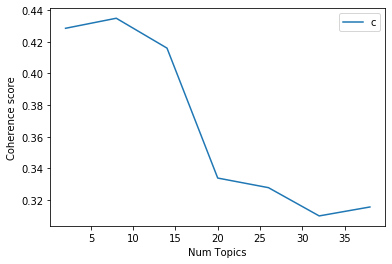

In [33]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
pyLDAvis.save_html(vis, 'lda.html')